In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow_probability as tfp

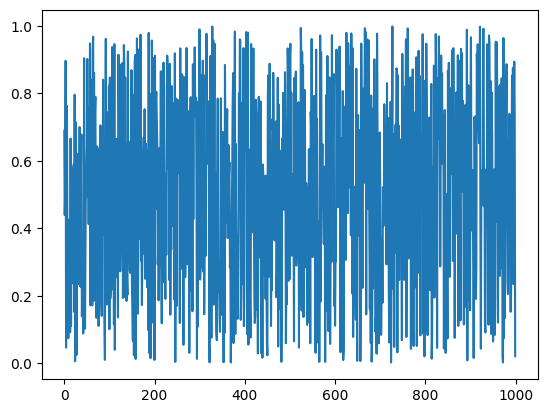

In [22]:
n = 50
p = 20
s = np.random.default_rng().uniform(0,1, n*p)
X = np.reshape(s,(-1, p))
X.shape
df = pd.DataFrame(X)
#  we let r=25
r= 2
y = np.zeros(n) #initialising y array
for i in range(n):
    yTemp = df.iloc[i,0:r].sum() + np.random.normal(0, 1) #generating y values from a simple linear model with gaussian noise
    y[i] = yTemp

plt.plot(s)

sigma1 = 1
sigma2 = 0.1
sigmay = 0.1
gamma = 0.1
rho = 1

In [8]:
def compNormal_include(theta_i, gamma, sigma1, sigma2):
    return (gamma * sigma2 * np.exp(-((theta_i**2)/(2*(sigma1**2)))))

def compNormal_exclude(theta_i, gamma, sigma1, sigma2):
    return ((sigma1-(gamma*sigma1)) * np.exp(-((theta_i**2)/(2*(sigma2**2)))))

def compNormal_data(theta, y, X, sigmay):
    ssum = 0
    for j in range(len(X)):
        ssum += ((y[j] - np.matmul(X[j], theta))**2)/(2*(sigmay**2))
    return ssum

def ssp(theta, gamma, sigma1, sigma2):
    ssum = 0
    for i in range(len(X[1])):
        ssum += np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2))
        # print(np.log(compNormal_include(theta[i], gamma, sigma1, sigma2) + compNormal_exclude(theta[i], gamma, sigma1, sigma2)))
    return ssum

In [ ]:
p = len(X[1])
n = len(X)
b = p + n
t = 1
niter = 100000
sigma_theta = 0.1
no_accept = 0
theta_0 = np.array([np.zeros(p)]).T                                   #initialising theta as zero vectors
for i in range(r): theta_0[i] = 1
thetas = theta_0.T[0]

while t < niter:
    t += 1
    #symmetric random walk
    theta_c = np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)*sigma_theta), (-1, 1))
    log_joint_candidate = ssp(theta_c, gamma, sigma1, sigma2) - compNormal_data(theta_c, y, X, sigmay)
    log_joint_old = ssp(theta_0, gamma, sigma1, sigma2) - compNormal_data(theta_0, y, X, sigmay)
    mhr = np.exp(log_joint_candidate - log_joint_old)[0]
    U = np.random.uniform()
    if U <= np.minimum(mhr, 1):
        theta_0 = theta_c
        thetas = np.vstack((thetas, theta_c.T[0]))
        no_accept += 1
        print("%sth acceptance" % str(no_accept))
    else:
        thetas = np.vstack((thetas, theta_0.T[0]))
        # print(thetas)
    # theta_0 = np.vstack(theta0, )

print(no_accept)
print(thetas[-1])

In [36]:
np.random.uniform()

0.7136366954494829

0.5050262537961243

In [67]:
def metroHastings(sigma1, sigma2, sigmay, X, y, niter = 1000):
    p = len(X[1])
    n = len(X)
    b = p + n
    t = 1
    sigma_theta = 0.1
    no_accept = 0
    theta_0 = np.array([np.zeros(p)]).T                                   #initialising theta as zero vectors
    # for i in range(r): theta_0[i] = 1
    thetas = theta_0.T[0]

    while t < niter:
        t += 1
        #symmetric random walk
        theta_c = np.reshape(np.random.multivariate_normal(np.zeros(p), np.identity(p)*sigma_theta), (-1, 1))
        log_joint_candidate = ssp(theta_c, gamma, sigma1, sigma2) - compNormal_data(theta_c, y, X, sigmay)
        log_joint_old = ssp(theta_0, gamma, sigma1, sigma2) - compNormal_data(theta_0, y, X, sigmay)
        mhr = np.exp(log_joint_candidate - log_joint_old)
        print(mhr)
        U = np.random.uniform(0,1)
        if U <= np.minimum(mhr, 1):
            theta_0 = theta_c
            thetas = np.vstack((thetas, theta_c.T[0]))
            no_accept += 1
        else:
            thetas = np.vstack((thetas, theta_0.T[0]))
            # print(thetas)
    
    print("Acceptance Rate is %s, with total number of acceptance of %s" % (str(no_accept/niter), str(no_accept)))
    return thetas

samples = metroHastings(sigma1 = 1, sigma2 = 0.1, sigmay = 0.1, X = X, y = y, niter = 100000)

[1.26886896e+37]
[inf]
[0.]
[0.]
[0.]
[3.14832761e-132]
[1.90655889e-70]
[0.]
[3.13840261e-206]
[0.]
[9.74744733e-278]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[3.4763347e-124]
[0.]
[5.52911018e-285]
[0.]
[0.]
[1.13041127e-304]
[0.]
[0.]
[0.]
[0.]
[6.4099856e-71]
[0.]
[0.]
[5.28752118e+33]
[3.86759223e-177]
[0.]
[0.]
[0.]
[0.]
[4.17179915e-122]
[0.]
[3.78391804e+238]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[4.80559659e-151]
[0.]
[0.]
[0.]
[4.76406995e-06]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[5.01309591e-296]
[1.35930349e-273]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[7.15087006e-301]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.47516965e-170]
[0.]
[0.]
[0.]
[1.05951494e-10]
[0.]
[0.]
[0.]
[0.]
[4.17877106e-272]
[0.]
[0.]
[0.]
[2.02299495e-51]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[2.06887734e-284]
[8.82949314e-171]
[0.]
[5.57071209e-211]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.16056258e-229]
[0.]
[0.]
[0.]
[0.]


C:\Users\Johnny Lee\AppData\Local\Temp\ipykernel_8800\669122867.py:18: RuntimeWarning: overflow encountered in exp
  mhr = np.exp(log_joint_candidate - log_joint_old)


[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[2.61646929e-258]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[7.74154909e-262]
[0.]
[0.]
[7.65984704e-231]
[2.53507534e-153]
[0.]
[0.]
[0.]
[0.]
[1.78679505e-175]
[0.]
[0.]
[0.]
[0.]
[3.24394221e+34]
[0.]
[1.21859416e-124]
[0.]
[0.]
[0.]
[0.]
[0.]
[6.73477754e-172]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[2.80909191e-164]
[0.]
[0.]
[6.89386559e-260]
[0.]
[0.]
[0.]
[2.67459141e-147]
[1.84331966e-284]
[0.]
[0.]
[4.00951263e-217]
[4.4520359e-311]
[1.70079099e-273]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[3.01173889e-153]
[0.]
[2.85980636e-90]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.82120305e-156]
[0.]
[0.]
[1.50322106e-240]
[1.92718936e-198]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[2.03887132e-204]
[0.]
[0.]
[0.]
[0.]
[5.46879009e-83]
[0.]
[2.45116068e-244]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


tf.Tensor(
[ 0.64409673  0.3187466  -0.10351058 -0.03422792  0.03864162  0.04341774
 -0.1206114   0.19959614 -0.08509584  0.29779276  0.04228207  0.30947998
 -0.18665205 -0.14637512  0.32467175  0.13487682 -0.14846778 -0.12950021
  0.16557522  0.0077897 ], shape=(20,), dtype=float32)


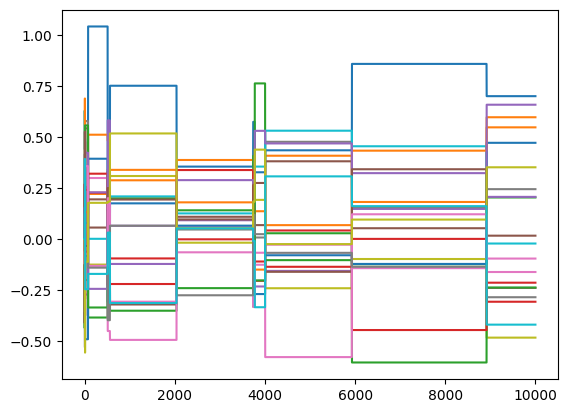

In [66]:
trace = tf.convert_to_tensor(samples, dtype = tf.float32)
plt.plot(trace)
mean, variance = tf.nn.moments(trace, axes=0)
print(mean)